# Classification du Type de Milieu : Lac vs Rivière

## Pourquoi c'est important ?

Les **lacs** et les **rivières** ont des dynamiques très différentes :

| Caractéristique | Lac (plan d'eau) | Rivière |
|-----------------|------------------|--------|
| Flux | Stagnant | Courant |
| Temps de résidence | Long | Court |
| Stratification | Oui (thermique) | Non |
| Dilution pollution | Lente | Rapide |
| Accumulation nutriments | Élevée | Faible |

→ Mélanger les deux dans un même modèle peut **dégrader les performances**.

## Méthode

On utilise les bases de données **HydroSHEDS** (référence scientifique mondiale) :

```
Point de mesure
      │
      ▼
┌─────────────────────────────┐
│  Est dans HydroLAKES ?      │───► OUI → "lake"
└─────────────────────────────┘
      │ NON
      ▼
┌─────────────────────────────┐
│  Distance < 100m de         │───► OUI → "river"
│  HydroRIVERS ?              │
└─────────────────────────────┘
      │ NON
      ▼
    "unknown"
```

## Sources de données

| Dataset | Description | Téléchargement |
|---------|-------------|----------------|
| **HydroLAKES** | 1.4 million de lacs mondiaux | [hydrosheds.org/products/hydrolakes](https://www.hydrosheds.org/products/hydrolakes) |
| **HydroRIVERS** | Réseau hydrographique mondial | [hydrosheds.org/products/hydrorivers](https://www.hydrosheds.org/products/hydrorivers) |

**Télécharger uniquement la région Afrique** pour réduire la taille des fichiers.

---

## Étape 1 : Installation et imports

In [1]:
# Installer geopandas si nécessaire
!pip install -q geopandas shapely pyproj


[notice] A new release of pip is available: 24.3.1 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from tqdm import tqdm
import os

print("Imports OK!")
print(f"Geopandas version: {gpd.__version__}")

Imports OK!
Geopandas version: 1.1.2


In [3]:
# =============================================================================
# CONFIGURATION
# =============================================================================

# Chemins vers les fichiers HydroSHEDS (déjà téléchargés dans data/raw)
HYDROLAKES_PATH = "../data/raw/HydroLAKES_polys_v10_shp/HydroLAKES_polys_v10.shp"  # Mondial
HYDRORIVERS_PATH = "../data/raw/HydroRIVERS_v10_af_shp/HydroRIVERS_v10_af.shp"     # Afrique

# Distance maximale pour considérer qu'un point est sur une rivière (en mètres)
# 200m choisi après analyse : capture 57% des points "unknown" (médiane = 177m)
RIVER_BUFFER_METERS = 200

# CRS pour les calculs de distance (UTM zone 35S pour Afrique du Sud)
UTM_CRS = "EPSG:32735"

# Fichiers d'entrée/sortie
TRAINING_FILE = "../data/raw/water_quality_training_dataset.csv"
SUBMISSION_FILE = "../data/raw/submission_template.csv"
OUTPUT_DIR = "../data/processed"

print(f"Configuration:")
print(f"  HydroLAKES: {HYDROLAKES_PATH}")
print(f"  HydroRIVERS: {HYDRORIVERS_PATH}")
print(f"  Buffer rivière: {RIVER_BUFFER_METERS}m")

Configuration:
  HydroLAKES: ../data/raw/HydroLAKES_polys_v10_shp/HydroLAKES_polys_v10.shp
  HydroRIVERS: ../data/raw/HydroRIVERS_v10_af_shp/HydroRIVERS_v10_af.shp
  Buffer rivière: 200m


---

## Étape 2 : Vérification des fichiers HydroSHEDS

Les fichiers sont déjà téléchargés dans `data/raw/` :

```
data/raw/
├── HydroLAKES_polys_v10_shp/
│   └── HydroLAKES_polys_v10.shp  (1.1 GB - mondial)
└── HydroRIVERS_v10_af_shp/
    └── HydroRIVERS_v10_af.shp    (237 MB - Afrique)
```

In [4]:
# Vérifier que les fichiers existent
import os

def check_file(path, name):
    if os.path.exists(path):
        size_mb = os.path.getsize(path) / (1024 * 1024)
        print(f"✅ {name}: {size_mb:.0f} MB")
        return True
    else:
        print(f"❌ {name} manquant: {path}")
        return False

print("Vérification des fichiers HydroSHEDS:")
lakes_ok = check_file(HYDROLAKES_PATH, "HydroLAKES")
rivers_ok = check_file(HYDRORIVERS_PATH, "HydroRIVERS")

if lakes_ok and rivers_ok:
    print("\n✅ Tous les fichiers sont présents, prêt à continuer!")

Vérification des fichiers HydroSHEDS:
✅ HydroLAKES: 1061 MB
✅ HydroRIVERS: 226 MB

✅ Tous les fichiers sont présents, prêt à continuer!


---

## Étape 3 : Chargement des données

In [5]:
# =============================================================================
# CHARGER LES DONNÉES HYDROSHED
# =============================================================================

print("Chargement de HydroLAKES...")
lakes = gpd.read_file(HYDROLAKES_PATH)
print(f"  → {len(lakes)} lacs chargés")

print("\nChargement de HydroRIVERS...")
rivers = gpd.read_file(HYDRORIVERS_PATH)
print(f"  → {len(rivers)} segments de rivière chargés")

# Filtrer pour l'Afrique du Sud (optionnel mais accélère les calculs)
# Bounding box approximative de l'Afrique du Sud
SA_BBOX = (15, -35, 33, -22)  # (min_lon, min_lat, max_lon, max_lat)

print("\nFiltrage pour l'Afrique du Sud...")
lakes_sa = lakes.cx[SA_BBOX[0]:SA_BBOX[2], SA_BBOX[1]:SA_BBOX[3]]
rivers_sa = rivers.cx[SA_BBOX[0]:SA_BBOX[2], SA_BBOX[1]:SA_BBOX[3]]

print(f"  → {len(lakes_sa)} lacs en Afrique du Sud")
print(f"  → {len(rivers_sa)} segments de rivière en Afrique du Sud")

Chargement de HydroLAKES...
  → 1427688 lacs chargés

Chargement de HydroRIVERS...
  → 1527551 segments de rivière chargés

Filtrage pour l'Afrique du Sud...
  → 2924 lacs en Afrique du Sud
  → 93142 segments de rivière en Afrique du Sud


In [6]:
# =============================================================================
# CHARGER LES POINTS DE MESURE
# =============================================================================

print("Chargement des données de qualité d'eau...")

# Training
training_df = pd.read_csv(TRAINING_FILE)
print(f"  Training: {len(training_df)} points")

# Submission
submission_df = pd.read_csv(SUBMISSION_FILE)
print(f"  Submission: {len(submission_df)} points")

Chargement des données de qualité d'eau...
  Training: 9319 points
  Submission: 200 points


---

## Étape 4 : Classification des points

In [7]:
def classify_water_type(df, lakes_gdf, rivers_gdf, river_buffer_m=100):
    """
    Classifie chaque point en 'lake', 'river', ou 'unknown'.
    
    Paramètres:
        df : DataFrame avec colonnes 'Latitude', 'Longitude'
        lakes_gdf : GeoDataFrame des lacs (polygones)
        rivers_gdf : GeoDataFrame des rivières (lignes)
        river_buffer_m : Distance max en mètres pour être considéré sur une rivière
    
    Retourne:
        DataFrame avec colonne 'water_type' ajoutée
    """
    df = df.copy()
    
    # Créer un GeoDataFrame des points
    print("Création des géométries des points...")
    geometry = [Point(lon, lat) for lon, lat in zip(df['Longitude'], df['Latitude'])]
    points_gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")
    
    # Initialiser la colonne water_type
    df['water_type'] = 'unknown'
    df['distance_to_lake'] = np.nan
    df['distance_to_river'] = np.nan
    
    # ==========================================================================
    # ÉTAPE 1 : Vérifier si le point est dans un lac
    # ==========================================================================
    print("\nÉtape 1: Recherche des points dans les lacs...")
    
    # Spatial join pour trouver les points dans les lacs
    points_in_lakes = gpd.sjoin(points_gdf, lakes_gdf, predicate='within', how='left')
    
    # Les points avec un index_right non-NaN sont dans un lac
    lake_mask = points_in_lakes['index_right'].notna()
    lake_indices = points_in_lakes[lake_mask].index.unique()
    
    df.loc[lake_indices, 'water_type'] = 'lake'
    print(f"  → {len(lake_indices)} points classés comme 'lake'")
    
    # ==========================================================================
    # ÉTAPE 2 : Pour les points restants, calculer la distance aux rivières
    # ==========================================================================
    print("\nÉtape 2: Calcul des distances aux rivières...")
    
    # Points non encore classés
    unknown_mask = df['water_type'] == 'unknown'
    unknown_indices = df[unknown_mask].index
    
    if len(unknown_indices) > 0:
        # Projeter en UTM pour calculer les distances en mètres
        points_utm = points_gdf.loc[unknown_indices].to_crs(UTM_CRS)
        rivers_utm = rivers_gdf.to_crs(UTM_CRS)
        
        # Union de toutes les rivières pour accélérer le calcul
        print("  Création de l'union des rivières (peut prendre du temps)...")
        rivers_union = rivers_utm.unary_union
        
        # Calculer la distance pour chaque point
        print(f"  Calcul des distances pour {len(unknown_indices)} points...")
        distances = []
        for idx in tqdm(unknown_indices, desc="  Distance aux rivières"):
            point = points_utm.loc[idx, 'geometry']
            dist = point.distance(rivers_union)
            distances.append(dist)
        
        # Classifier les points proches des rivières
        for i, idx in enumerate(unknown_indices):
            df.loc[idx, 'distance_to_river'] = distances[i]
            if distances[i] <= river_buffer_m:
                df.loc[idx, 'water_type'] = 'river'
    
    # ==========================================================================
    # RÉSUMÉ
    # ==========================================================================
    print("\n" + "="*50)
    print("RÉSUMÉ DE LA CLASSIFICATION")
    print("="*50)
    print(df['water_type'].value_counts())
    
    return df

In [8]:
# =============================================================================
# CLASSIFICATION DES DONNÉES TRAINING
# =============================================================================

print("Classification des données TRAINING")
print("="*50)

training_classified = classify_water_type(
    training_df,
    lakes_sa,
    rivers_sa,
    river_buffer_m=RIVER_BUFFER_METERS
)

Classification des données TRAINING
Création des géométries des points...

Étape 1: Recherche des points dans les lacs...
  → 27 points classés comme 'lake'

Étape 2: Calcul des distances aux rivières...
  Création de l'union des rivières (peut prendre du temps)...
  Calcul des distances pour 9292 points...


  Distance aux rivières: 100%|██████████| 9292/9292 [01:50<00:00, 83.74it/s] 



RÉSUMÉ DE LA CLASSIFICATION
water_type
river      7392
unknown    1900
lake         27
Name: count, dtype: int64


In [9]:
# =============================================================================
# CLASSIFICATION DES DONNÉES SUBMISSION
# =============================================================================

print("\nClassification des données SUBMISSION")
print("="*50)

submission_classified = classify_water_type(
    submission_df,
    lakes_sa,
    rivers_sa,
    river_buffer_m=RIVER_BUFFER_METERS
)


Classification des données SUBMISSION
Création des géométries des points...

Étape 1: Recherche des points dans les lacs...
  → 0 points classés comme 'lake'

Étape 2: Calcul des distances aux rivières...
  Création de l'union des rivières (peut prendre du temps)...
  Calcul des distances pour 200 points...


  Distance aux rivières: 100%|██████████| 200/200 [00:02<00:00, 81.14it/s]



RÉSUMÉ DE LA CLASSIFICATION
water_type
river      185
unknown     15
Name: count, dtype: int64


---

## Étape 5 : Sauvegarde des résultats

In [10]:
# =============================================================================
# SAUVEGARDE
# =============================================================================

# Sélectionner les colonnes à sauvegarder
output_cols = ['Latitude', 'Longitude', 'Sample Date', 'water_type', 'distance_to_river']

# Training
training_output = training_classified[output_cols]
training_path = os.path.join(OUTPUT_DIR, 'water_type_training.csv')
training_output.to_csv(training_path, index=False)
print(f"✅ Training sauvegardé: {training_path}")

# Submission
submission_output = submission_classified[output_cols]
submission_path = os.path.join(OUTPUT_DIR, 'water_type_validation.csv')
submission_output.to_csv(submission_path, index=False)
print(f"✅ Submission sauvegardé: {submission_path}")

✅ Training sauvegardé: ../data/processed\water_type_training.csv
✅ Submission sauvegardé: ../data/processed\water_type_validation.csv


In [11]:
# Aperçu des résultats
print("\nAperçu des résultats TRAINING :")
display(training_output.head(10))

print("\nDistribution par type :")
print(training_output['water_type'].value_counts())

print("\nStatistiques distance aux rivières (pour les non-lacs) :")
print(training_output[training_output['water_type'] != 'lake']['distance_to_river'].describe())


Aperçu des résultats TRAINING :


,Latitude,Longitude,Sample Date,water_type,distance_to_river
0,-28.760833,17.730278,02-01-2011,river,46.592505
1,-26.861111,28.884722,03-01-2011,river,69.035778
2,-26.450000,28.085833,03-01-2011,river,123.538285
3,-27.671111,27.236944,03-01-2011,river,20.518409
4,-27.356667,27.286389,03-01-2011,river,46.165896
5,-27.010111,26.698083,04-01-2011,river,10.264875
6,-25.127778,27.628889,04-01-2011,river,82.823808
7,-25.206390,27.558000,04-01-2011,river,176.983129
8,-24.695140,27.409060,04-01-2011,unknown,558.737308
9,-26.984722,26.632278,04-01-2011,river,24.633358



Distribution par type :
water_type
river      7392
unknown    1900
lake         27
Name: count, dtype: int64

Statistiques distance aux rivières (pour les non-lacs) :
count    9292.000000
mean      140.637208
std       163.929807
min         0.020087
25%        40.488967
50%        85.004613
75%       176.983129
max      1457.912439
Name: distance_to_river, dtype: float64


---

## Étape 6 : Visualisation (optionnel)

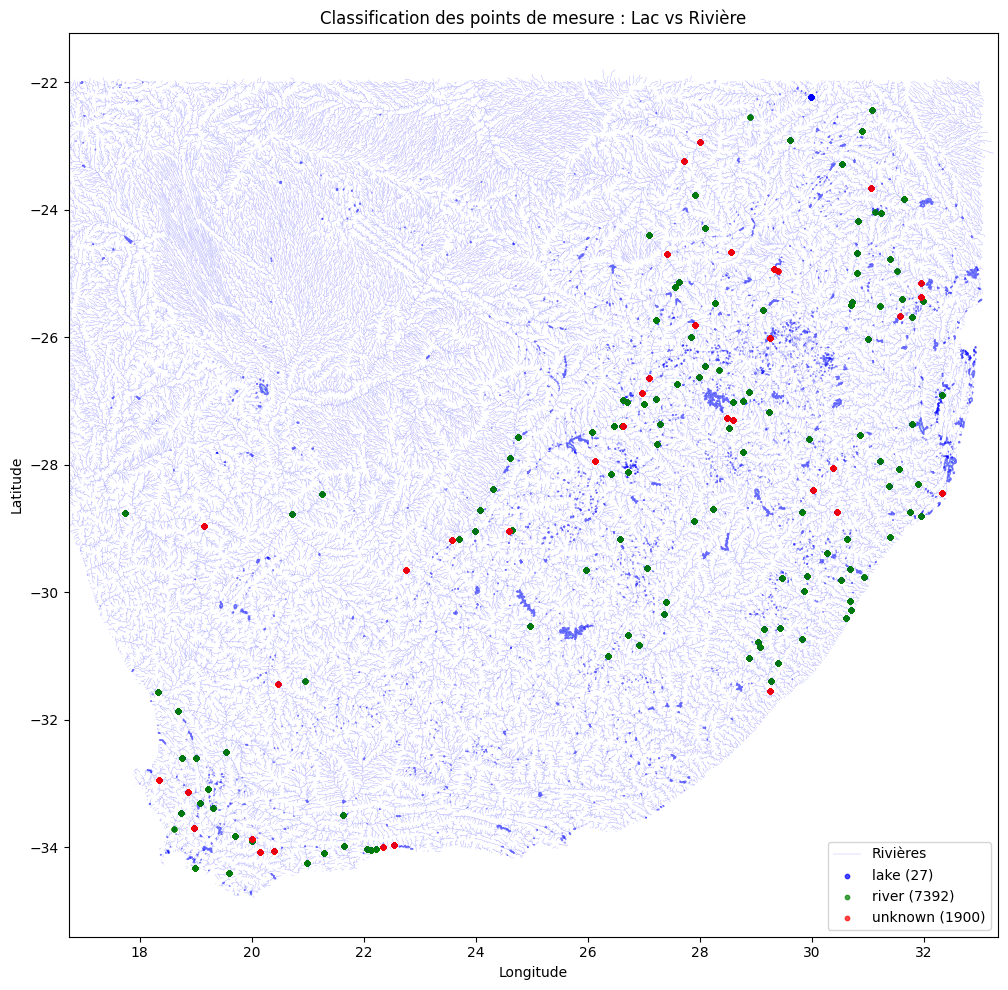


Figure sauvegardée: outputs/figures/water_type_classification.png


In [12]:
import matplotlib.pyplot as plt

# Créer un GeoDataFrame pour la visualisation
geometry = [Point(lon, lat) for lon, lat in zip(training_classified['Longitude'], training_classified['Latitude'])]
points_viz = gpd.GeoDataFrame(training_classified, geometry=geometry, crs="EPSG:4326")

# Carte
fig, ax = plt.subplots(figsize=(12, 10))

# Fond : lacs et rivières
lakes_sa.plot(ax=ax, color='lightblue', edgecolor='blue', alpha=0.5, label='Lacs')
rivers_sa.plot(ax=ax, color='blue', linewidth=0.3, alpha=0.3, label='Rivières')

# Points colorés par type
colors = {'lake': 'blue', 'river': 'green', 'unknown': 'red'}
for water_type, color in colors.items():
    mask = points_viz['water_type'] == water_type
    points_viz[mask].plot(ax=ax, color=color, markersize=10, label=f'{water_type} ({mask.sum()})', alpha=0.7)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Classification des points de mesure : Lac vs Rivière')
ax.legend(loc='lower right')

# Zoom sur la zone avec des points
ax.set_xlim(training_classified['Longitude'].min() - 1, training_classified['Longitude'].max() + 1)
ax.set_ylim(training_classified['Latitude'].min() - 1, training_classified['Latitude'].max() + 1)

plt.tight_layout()
plt.savefig('../outputs/figures/water_type_classification.png', dpi=150)
plt.show()

print("\nFigure sauvegardée: outputs/figures/water_type_classification.png")

---

## Résumé

### Méthode utilisée

1. **HydroLAKES** : Point dans un polygone de lac → `lake`
2. **HydroRIVERS** : Point à < 100m d'une rivière → `river`
3. Sinon → `unknown`

### Fichiers créés

| Fichier | Colonnes | Description |
|---------|----------|-------------|
| water_type_training.csv | Lat, Lon, Date, water_type, distance_to_river | Classification training |
| water_type_validation.csv | Lat, Lon, Date, water_type, distance_to_river | Classification validation |

### Utilisation dans le modèle

```python
# Option 1 : Variable catégorielle
df = df.merge(water_type_df, on=['Latitude', 'Longitude', 'Sample Date'])
df = pd.get_dummies(df, columns=['water_type'])

# Option 2 : Deux modèles séparés
df_lake = df[df['water_type'] == 'lake']
df_river = df[df['water_type'] == 'river']
model_lake = RandomForestRegressor().fit(X_lake, y_lake)
model_river = RandomForestRegressor().fit(X_river, y_river)
```

### Points "unknown"

Les points `unknown` peuvent être :
- Des petits cours d'eau non répertoriés
- Des mares temporaires
- Des erreurs de géolocalisation

→ On peut les traiter comme des rivières (hypothèse conservatrice) ou les exclure de l'analyse.